#**1 Introduccion**
En el siguiente cuaderno se realizara la aplicacion del filtro Sobel a una imagen parametrizada. 

Se aplica el **Operdador Sobel**[1], el mismo calcula el gradiente de la intensidad de una imagen en cada punto (píxel). Así, para cada punto, este operador da la magnitud del mayor cambio posible, la dirección de este y el sentido desde oscuro a claro. El resultado muestra cómo de abruptamente o suavemente cambia una imagen en cada punto analizado y, en consecuencia, cuán probable es que este represente un borde en la imagen y, también, la orientación a la que tiende ese borde.


#**2 Armado del Ambiente**


##2.1 Instala en el cuaderno el modulo de OpenCL de Python

In [11]:
!pip install pyopencl

##2.2 Cagar el archivo con el codigo fuente

In [12]:
url_archivo = "https://github.com/BelMerida/Merida-SOA/blob/master/HPC/EJERCICIO%203/sobel.c?raw=true" 

!wget {url_archivo} -O sobel.c

--2020-11-22 16:24:02--  https://github.com/BelMerida/Merida-SOA/blob/master/HPC/EJERCICIO%203/sobel.c?raw=true
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BelMerida/Merida-SOA/raw/master/HPC/EJERCICIO%203/sobel.c [following]
--2020-11-22 16:24:02--  https://github.com/BelMerida/Merida-SOA/raw/master/HPC/EJERCICIO%203/sobel.c
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BelMerida/Merida-SOA/master/HPC/EJERCICIO%203/sobel.c [following]
--2020-11-22 16:24:03--  https://raw.githubusercontent.com/BelMerida/Merida-SOA/master/HPC/EJERCICIO%203/sobel.c
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.

##2.3 Parametros de Ejecucion
Toma la direcciòn web de una imagen con acceso público en internet, la deja disponible al contexto de ejecuciòn del cuaderno colab.

In [13]:
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/BelMerida/Merida-SOA/blob/master/HPC/EJERCICIO%203/tree.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/BelMerida/Merida-SOA/blob/master/HPC/EJERCICIO%203/tree.jpg -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg

--2020-11-22 16:24:12--  https://github.com/BelMerida/Merida-SOA/blob/master/HPC/EJERCICIO%203/tree.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/BelMerida/Merida-SOA/raw/master/HPC/EJERCICIO%203/tree.jpg [following]
--2020-11-22 16:24:12--  https://github.com/BelMerida/Merida-SOA/raw/master/HPC/EJERCICIO%203/tree.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BelMerida/Merida-SOA/master/HPC/EJERCICIO%203/tree.jpg [following]
--2020-11-22 16:24:12--  https://raw.githubusercontent.com/BelMerida/Merida-SOA/master/HPC/EJERCICIO%203/tree.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.1

#**3 Desarrollo**

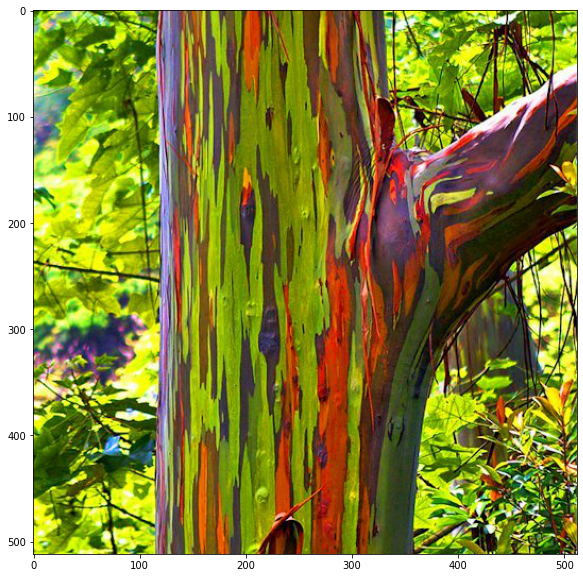

(3, 512, 512) float32
0.0 0.46042198


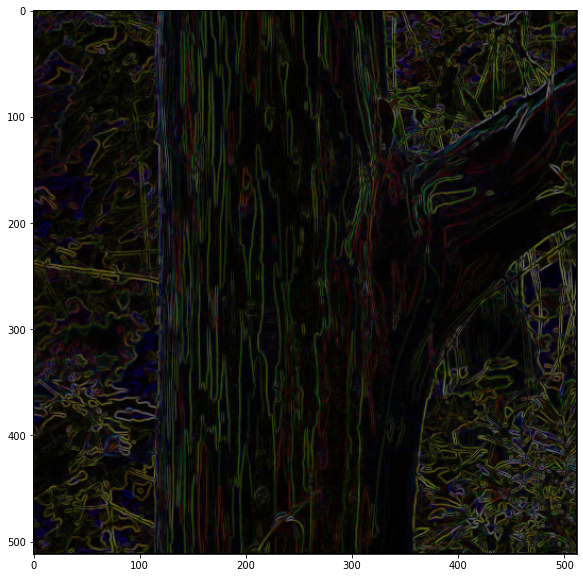

In [14]:
from __future__ import absolute_import, print_function
import matplotlib.pyplot as plt
import pyopencl as cl
import numpy as np
from cv2 import resize

#Inicializar contexto y cola de ejecución

ID_P = 0
ID_D = 0
platforms = cl.get_platforms()
devices = [platforms[ID_P].get_devices()[ID_D]]
context = cl.Context(devices=devices,properties=[(cl.context_properties.PLATFORM, platforms[ID_P])])
context.get_info(cl.context_info.DEVICES)
queue = cl.CommandQueue(context, properties=cl.command_queue_properties.OUT_OF_ORDER_EXEC_MODE_ENABLE)
queue.get_info(cl.command_queue_info.CONTEXT)

#Compilacion del codigo fuente

try:
  source_file=open("sobel.c","r")
except IOError:
    print ("Error de entrada/salida." )
kernel = source_file.read()
source_file.close()

prg = cl.Program(context, kernel)
exe = prg.build(options=[])

#Imagen
size=512
host_color = (plt.imread("imagen.jpg")/255).astype(np.float32)
host_color = resize(host_color,(size,size))

plt.figure(figsize=(10,10))
plt.imshow(host_color,'gray')
plt.show()

host_color = np.transpose(host_color, [2, 0, 1]).copy()

print(host_color.shape,host_color.dtype )

#Inicialización de memoria y copia al dispositivo

device_color = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=host_color.nbytes)
device_sobel = cl.Buffer(context, cl.mem_flags.READ_WRITE, size=host_color.nbytes)
cl.enqueue_copy(queue, device_color, host_color, is_blocking=False, wait_for=None)
cl.enqueue_fill_buffer(queue, device_sobel, pattern=np.float32(0),size=4,offset=0)

#Ejecucion del kernel

host_color.fill(0.)            
exe_event=exe.sobel(queue, (size-2,size-2,3), None, device_color, device_sobel, wait_for=None)
cl.enqueue_copy(queue, host_color, device_sobel, is_blocking=True, wait_for=None)

image = np.transpose(host_color, [1, 2, 0]).copy()


print(image.min(),image.max())

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

#**4 Tabla de Pasos**

Procesador | Funciòn | Detalle
------------|---------|----------
CPU      | pip install pyopencl    | Instala en el cuaderno los driver de OpenCL para Python.
CPU| wget url_archivo| Cargar el archivo que contiene el codigo fuente
CPU      |  wget url_imagen       | Lectura de la direcciòn URL de la imagen (jpg) a procesar.
CPU      |  import                | Importa los módulos para funcionar.
CPU| source_file=open("sobel.c","r")| Abro el archivo que contiene el codigo fuente
CPU|kernel = source_file.read()| Creo el kernel.
**GPU**| cl.Program(context, kernel)| Compilacion del codigo Fuente.
**GPU**      |  cl.Context()        | Inicializo el contexto. 
**GPU**| cl.CommandQueue()| Inicializo cola de ejecucion.
CPU      |  host_color = (plt.imread("imagen.jpg")/255).astype(np.float32)         | Abre el archivo de la imagen.
CPU      |  plt.imshow            | Muestra la imagen original.
**GPU**  |  cl.Buffer()      | Reserva la memoria en GPU.
**GPU**  |  cl.enqueue_copy()    | Copio los valores al GPU.
**GPU**  |  exe.sobel()              | Ejecuta el kernel en GPU.
CPU      |  plt.imshow            | Muestra la imagen resultado.

#**5 Conclusion**
Para el algoritmo se utilizo OpenCL[2,3] ya que la misma aprovecha la potencia de los procesadores gráficos para realizar operaciones intensas repartidas entre el procesador del equipo (CPU) y la GPU.

#**6 Bibliografia**
[1] Operador Sobel: [WEB](https://en.wikipedia.org/wiki/Sobel_operator)

[2] Wiki Sistemas Operativos Avanzados: [WIKI](http://www.so-unlam.net.ar/wiki/index.php/PUBLICO:HPC)

[3] OpenCL: [WEB](https://riptutorial.com/es/opencl/topic/10169/configuracion-basica-de-opencl)